# validate results

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [88]:
import os
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
from numpy.random import default_rng

from activitysim.cli import run
from activitysim.core import inject

from fru_utils import run_trip_mode_choice, comp_mode_shares

In [89]:
pd.set_option("max_columns", 500)

In [90]:
root_dir = "/mnt/c/Users/jan.zill/code/activitysim"
example_dir = os.path.join(root_dir, "test_example_mtc")

In [91]:
os.chdir(example_dir)

In [92]:
parser = argparse.ArgumentParser()
run.add_run_args(parser)
# args = parser.parse_args()
# parser.parse_args(['--sum', '7', '-1', '42'])
args = parser.parse_args(['-c', 'configs', '-o', 'output', '-d', 'data'])
#run.run(args)  # 2mins full example run
if not inject.is_injectable('preload_injectables'):
    from activitysim import abm  # register abm steps and other abm-specific injectables
run.handle_standard_args(args)  # possibly update injectables

In [93]:
%%time
trips_df_ru = run_trip_mode_choice()
trips_df = run_trip_mode_choice(choose_individual_max_utility=False)

register joint_tour_participants: no rows with household_id in [982875].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)


register joint_tour_participants: no rows with household_id in [982875].


Done


estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)
Done
CPU times: user 21.5 s, sys: 2.27 s, total: 23.8 s
Wall time: 21.1 s


In [94]:
c_ = ["trip_mode", "mode_choice_logsum"]
trips = trips_df_ru[c_].merge(trips_df[c_], left_index=True, right_index=True, how="outer", suffixes=["_fru", "_asim"])
pd.merge(trips_df_ru.trip_mode.value_counts(), trips_df.trip_mode.value_counts(), left_index=True, right_index=True,
         suffixes=["_fru", "_asim"])

,trip_mode_fru,trip_mode_asim
WALK,297,304
WALK_LOC,100,85
WALK_LRF,52,53
BIKE,16,17
DRIVEALONEFREE,7,4
WALK_HVY,4,4
TNC_SINGLE,3,4
SHARED2FREE,2,4
TNC_SHARED,1,4


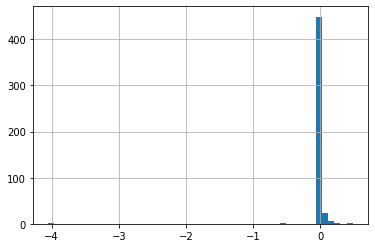

In [95]:
if np.allclose(trips.mode_choice_logsum_fru, trips.mode_choice_logsum_asim):
    print("Logsums agree")
else:
    ((trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) / trips.mode_choice_logsum_fru).hist(bins=50)

In [96]:
x_ = np.abs(trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim)
x_.loc[x_ > 0.1]

trip_id
535694417     0.143382
943749469     0.109040
1004301761    0.122286
1767182865    0.119168
1767183297    0.138448
1767186581    0.111968
dtype: float64

# Run MC validation

see logit._each_nest parent_nest_scale for leaf node, and simulate.compute_nested_utilities for discussion of scales
of alternatives

easiest way is to run a simulation

In [104]:
from fru_utils import get_stuff
t, ru, neu, nu, ns, nested_probs, base_probs = get_stuff(do_these_purposes=["social"])

register joint_tour_participants: no rows with household_id in [982875].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'social' (19 trips)
Done


In [105]:
nest_spec = ns[0]
for nest in logit.each_nest(nest_spec, type='node', post_order=False):
    nest.print()

Nest name: root level: 1 coefficient: 1.0 product_of_coefficients: 1.0 ancestors: ['root'] 
Nest name: AUTO level: 2 coefficient: 0.72 product_of_coefficients: 0.72 ancestors: ['root', 'AUTO'] 
Nest name: DRIVEALONE level: 3 coefficient: 0.35 product_of_coefficients: 0.252 ancestors: ['root', 'AUTO', 'DRIVEALONE'] 
Nest name: SHAREDRIDE2 level: 3 coefficient: 0.35 product_of_coefficients: 0.252 ancestors: ['root', 'AUTO', 'SHAREDRIDE2'] 
Nest name: SHAREDRIDE3 level: 3 coefficient: 0.35 product_of_coefficients: 0.252 ancestors: ['root', 'AUTO', 'SHAREDRIDE3'] 
Nest name: NONMOTORIZED level: 2 coefficient: 0.72 product_of_coefficients: 0.72 ancestors: ['root', 'NONMOTORIZED'] 
Nest name: TRANSIT level: 2 coefficient: 0.72 product_of_coefficients: 0.72 ancestors: ['root', 'TRANSIT'] 
Nest name: WALKACCESS level: 3 coefficient: 0.5 product_of_coefficients: 0.36 ancestors: ['root', 'TRANSIT', 'WALKACCESS'] 
Nest name: DRIVEACCESS level: 3 coefficient: 0.5 product_of_coefficients: 0.36 ance

In [106]:
base_probs[0]

,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
trip_id,,,,,,,,,,,,,,,,,,,,,
8805121,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.266799e-08,7.843494e-08,2.071998e-08
8805125,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.057327e-08,7.325707e-08,1.950799e-08
8805126,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.864169e-08,9.376443e-08,2.428075e-08
468119921,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.096638e-08,2.754998e-10,4.051502e-08
468119922,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.999874,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.658716e-05,6.599176e-07,9.832967e-05
468119925,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.999875,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.651144e-05,6.601311e-07,9.831370e-05
468119926,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.568041e-08,2.408144e-10,3.615344e-08
468119927,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.308505e-08,1.315547e-10,2.041405e-08
468119928,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.367465e-09,1.493582e-10,1.939597e-08


In [100]:
choose_individual_max_utility = False
num_samples = 10000
trip_id_to_check = 2464104885
ms_comp = comp_mode_shares(base_probs, choose_individual_max_utility, num_samples, trip_id_to_check)
display(ms_comp.loc[((ms_comp.mode_share_obs != 0) | (ms_comp.trip_mode != 0)), ["mode_share_obs", "trip_mode"]].T)

register joint_tour_participants: no rows with household_id in [982875].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'social' (10000 trips)
Done


,SHARED2FREE,SHARED3FREE,TAXI,TNC_SHARED,TNC_SINGLE,WALK,WALK_LOC
mode_share_obs,0.000022,2.084422e-16,1.325277e-07,3.433307e-07,8.507634e-12,0.627973,0.372005
trip_mode,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.620900,0.379100


In [107]:
choose_individual_max_utility = True
num_samples = 10000  # 1e5 takes about 25s
trip_id_to_check = 1767182945 # 2464104885 # 642446345 # 1767182945
ms_comp = comp_mode_shares(base_probs, choose_individual_max_utility, num_samples, trip_id_to_check)
display(ms_comp.loc[((ms_comp.mode_share_obs != 0) | (ms_comp.trip_mode != 0)), ["mode_share_obs", "trip_mode"]].T)

register joint_tour_participants: no rows with household_id in [982875].
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'social' (10000 trips)
Done


,SHARED2FREE,SHARED3FREE,TAXI,TNC_SHARED,TNC_SINGLE,WALK,WALK_LOC,WALK_LRF
mode_share_obs,0.016101,1.548643e-13,0.001499,0.000854,0.003359,0.046835,0.144256,0.787096
trip_mode,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.012600,0.223600,0.763800
